In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
adata = ad.read_h5ad('Mouse_brain_cell_bin.h5ad')

In [3]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)

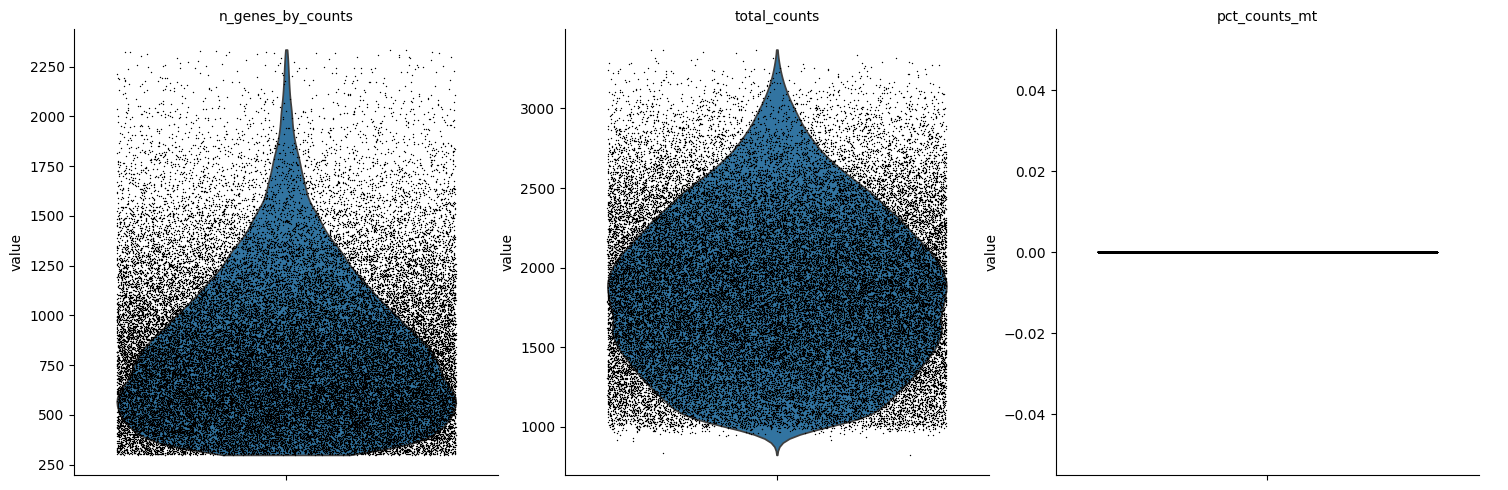

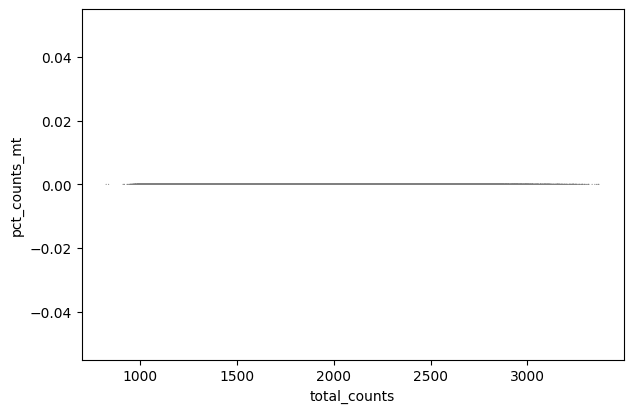

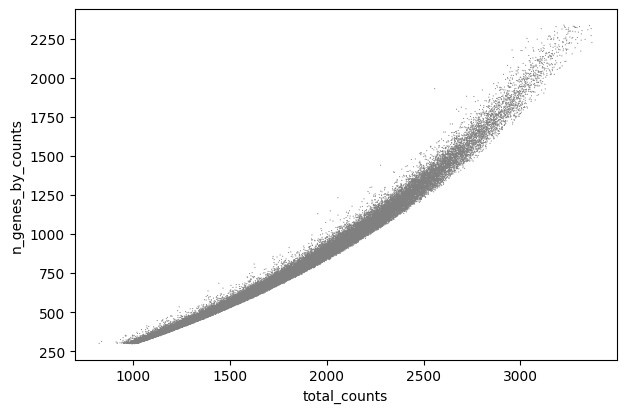

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :].copy()

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [7]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [11]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [8]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)

In [13]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the spatial coordinates
spatial_coords = adata.obsm['spatial']
spatial_coords_standardized = scaler.fit_transform(spatial_coords)

# Fit and transform the PCA features
pca_features = adata.obsm['X_pca']
pca_features_standardized = scaler.fit_transform(pca_features)

# Concatenate the standardized PCA features and spatial coordinates
X = scaler.fit_transform(np.hstack([pca_features, spatial_coords]))

Y = adata.obs['annotation'].to_numpy()
cell_Indexes = adata.obs.index.to_numpy()

# Generate a permutation of index array
np.random.seed(42)  # for reproducibility, you can remove or change the seed if randomness is preferred
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle X and Y and Cell_Indexes using the same indices
X_shuffled = X[indices]
Y_shuffled = Y[indices]
cell_Indexes_shuffled = cell_Indexes[indices]

In [10]:
# Define the number of folds and L value
K = 5
L = 3  # This value should be chosen based on your specific requirements

# Initialize StratifiedKFold and classifier
skf = StratifiedKFold(n_splits=K)

# Izaberi jedno od ova dva

#classifier1 = GradientBoostingClassifier(n_estimators=10, learning_rate=0.5, max_depth=3) 
#classifier2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=8000)  
#classifier3 = RandomForestClassifier()
#classifier4 = KNeighborsClassifier(n_neighbors=5)
#classifier5 = SVC(kernel='rbf', C=1.0, gamma='scale')  
#classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5]

classifier1 = SVC(kernel='rbf', C=1.0, gamma='scale')  
classifier2 = KNeighborsClassifier(n_neighbors=20)
classifier3 = KNeighborsClassifier(n_neighbors=20)
classifier4 = KNeighborsClassifier(n_neighbors=20)
classifier5 = KNeighborsClassifier(n_neighbors=20)
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5] 

# Initialize predictions dictionary with keys as cell indexes and values as empty lists or arrays of size K
predictions = {index: np.empty(K, dtype=object) for index in cell_Indexes_shuffled}

# Metrics storage
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [11]:
# Training and prediction
fold = 0
while fold < K:
    for train_index, test_index in skf.split(X_shuffled, Y_shuffled):
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = Y_shuffled[train_index], Y_shuffled[test_index]
        cell_indexes_test = cell_Indexes_shuffled[test_index]  # Get the cell indexes for the test set

        classifier = classifiers[fold]

        # Train the model
        classifier.fit(X_train, y_train)
        
        # Predict on the test set
        preds = classifier.predict(X_test)
        
        # Store predictions in the dictionary using the cell indexes
        for idx, cell_index in enumerate(cell_indexes_test):
            predictions[cell_index][fold] = preds[idx]
        
        # Evaluate predictions
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, average='macro', zero_division=1)
        rec = recall_score(y_test, preds, average='macro')
        f1 = f1_score(y_test, preds, average='macro')

        # Print metrics
        print(f"Fold {fold+1} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

        # Append metrics to lists for average calculation later
        accuracy_scores.append(acc)
        precision_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1)
    print("")
    fold += 1

Fold 1 - Accuracy: 0.4925164208032734, Precision: 0.594845800375609, Recall: 0.307411271715104, F1 Score: 0.3148854081250769


KeyboardInterrupt: 

In [29]:
# Calculate and print average scores
print("Average Accuracy:", np.mean(accuracy_scores))
print("Average Precision:", np.mean(precision_scores))
print("Average Recall:", np.mean(recall_scores))
print("Average F1 Score:", np.mean(f1_scores))

Average Accuracy: 0.528803704102509
Average Precision: 0.5299984183007561
Average Recall: 0.44541409396399745
Average F1 Score: 0.47097492182609935


In [30]:
from collections import Counter
helper = 0
# Process each cell index and its predictions
for cell_index, preds in predictions.items():
    # Count occurrences of each annotation
    pred_count = Counter(preds)

    most_common_pred, count = pred_count.most_common(1)[0]
    
    if count > L:
        if adata.obs.loc[cell_index, 'annotation'] != most_common_pred:
            #adata.obs.loc[cell_index, 'annotation'] = most_common_pred
            helper += 1

print(helper)

21880
